# Project: Part of Speech Tagging with Hidden Markov Models 
---
### Introduction

Part of speech tagging is the process of determining the syntactic category of a word from the words in its surrounding context. It is often used to help disambiguate natural language phrases because it can be done quickly with high accuracy. Tagging can be used for many NLP tasks like determining correct pronunciation during speech synthesis (for example, _dis_-count as a noun vs dis-_count_ as a verb), for information retrieval, and for word sense disambiguation.

In this notebook, you'll use the [Pomegranate](http://pomegranate.readthedocs.io/) library to build a hidden Markov model for part of speech tagging using a "universal" tagset. Hidden Markov models have been able to achieve [>96% tag accuracy with larger tagsets on realistic text corpora](http://www.coli.uni-saarland.de/~thorsten/publications/Brants-ANLP00.pdf). Hidden Markov models have also been used for speech recognition and speech generation, machine translation, gene recognition for bioinformatics, and human gesture recognition for computer vision, and more. 

![](_post-hmm.png)

The notebook already contains some code to get you started. You only need to add some new functionality in the areas indicated to complete the project; you will not need to modify the included code beyond what is requested. Sections that begin with **'IMPLEMENTATION'** in the header indicate that you must provide code in the block that follows. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully!

<div class="alert alert-block alert-info">
**Note:** Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You must then **export the notebook** by running the last cell in the notebook, or by using the menu above and navigating to **File -> Download as -> HTML (.html)** Your submissions should include both the `html` and `ipynb` files.
</div>

<div class="alert alert-block alert-info">
**Note:** Code and Markdown cells can be executed using the `Shift + Enter` keyboard shortcut. Markdown cells can be edited by double-clicking the cell to enter edit mode.
</div>

### The Road Ahead
You must complete Steps 1-3 below to pass the project. The section on Step 4 includes references & resources you can use to further explore HMM taggers.

- [Step 1](#Step-1:-Read-and-preprocess-the-dataset): Review the provided interface to load and access the text corpus
- [Step 2](#Step-2:-Build-a-Most-Frequent-Class-tagger): Build a Most Frequent Class tagger to use as a baseline
- [Step 3](#Step-3:-Build-an-HMM-tagger): Build an HMM Part of Speech tagger and compare to the MFC baseline
- [Step 4](#Step-4:-[Optional]-Improving-model-performance): (Optional) Improve the HMM tagger

<div class="alert alert-block alert-warning">
**Note:** Make sure you have selected a **Python 3** kernel in Workspaces or the hmm-tagger conda environment if you are running the Jupyter server on your own machine.
</div>

In [1]:
# Jupyter "magic methods" -- only need to be run once per kernel restart
%load_ext autoreload
%aimport helpers, tests
%autoreload 1

In [2]:
# import python modules -- this cell needs to be run again if you make changes to any of the files
import matplotlib.pyplot as plt
import numpy as np

from IPython.core.display import HTML
from itertools import chain
from collections import Counter, defaultdict
from helpers import show_model, Dataset
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

## Step 1: Read and preprocess the dataset
---
We'll start by reading in a text corpus and splitting it into a training and testing dataset. The data set is a copy of the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) (originally from the [NLTK](https://www.nltk.org/) library) that has already been pre-processed to only include the [universal tagset](https://arxiv.org/pdf/1104.2086.pdf). You should expect to get slightly higher accuracy using this simplified tagset than the same model would achieve on a larger tagset like the full [Penn treebank tagset](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html), but the process you'll follow would be the same.

The `Dataset` class provided in helpers.py will read and parse the corpus. You can generate your own datasets compatible with the reader by writing them to the following format. The dataset is stored in plaintext as a collection of words and corresponding tags. Each sentence starts with a unique identifier on the first line, followed by one tab-separated word/tag pair on each following line. Sentences are separated by a single blank line.

Example from the Brown corpus. 
```
b100-38532
Perhaps	ADV
it	PRON
was	VERB
right	ADJ
;	.
;	.

b100-35577
...
```

In [3]:
data = Dataset("tags-universal.txt", "brown-universal.txt", train_test_split=0.8)

print("There are {} sentences in the corpus.".format(len(data)))
print("There are {} sentences in the training set.".format(len(data.training_set)))
print("There are {} sentences in the testing set.".format(len(data.testing_set)))

assert len(data) == len(data.training_set) + len(data.testing_set), \
       "The number of sentences in the training set + testing set should sum to the number of sentences in the corpus"

There are 57340 sentences in the corpus.
There are 45872 sentences in the training set.
There are 11468 sentences in the testing set.


### The Dataset Interface

You can access (mostly) immutable references to the dataset through a simple interface provided through the `Dataset` class, which represents an iterable collection of sentences along with easy access to partitions of the data for training & testing. Review the reference below, then run and review the next few cells to make sure you understand the interface before moving on to the next step.

```
Dataset-only Attributes:
    training_set - reference to a Subset object containing the samples for training
    testing_set - reference to a Subset object containing the samples for testing

Dataset & Subset Attributes:
    sentences - a dictionary with an entry {sentence_key: Sentence()} for each sentence in the corpus
    keys - an immutable ordered (not sorted) collection of the sentence_keys for the corpus
    vocab - an immutable collection of the unique words in the corpus
    tagset - an immutable collection of the unique tags in the corpus
    X - returns an array of words grouped by sentences ((w11, w12, w13, ...), (w21, w22, w23, ...), ...)
    Y - returns an array of tags grouped by sentences ((t11, t12, t13, ...), (t21, t22, t23, ...), ...)
    N - returns the number of distinct samples (individual words or tags) in the dataset

Methods:
    stream() - returns an flat iterable over all (word, tag) pairs across all sentences in the corpus
    __iter__() - returns an iterable over the data as (sentence_key, Sentence()) pairs
    __len__() - returns the nubmer of sentences in the dataset
```

For example, consider a Subset, `subset`, of the sentences `{"s0": Sentence(("See", "Spot", "run"), ("VERB", "NOUN", "VERB")), "s1": Sentence(("Spot", "ran"), ("NOUN", "VERB"))}`. The subset will have these attributes:

```
subset.keys == {"s1", "s0"}  # unordered
subset.vocab == {"See", "run", "ran", "Spot"}  # unordered
subset.tagset == {"VERB", "NOUN"}  # unordered
subset.X == (("Spot", "ran"), ("See", "Spot", "run"))  # order matches .keys
subset.Y == (("NOUN", "VERB"), ("VERB", "NOUN", "VERB"))  # order matches .keys
subset.N == 7  # there are a total of seven observations over all sentences
len(subset) == 2  # because there are two sentences
```

<div class="alert alert-block alert-info">
**Note:** The `Dataset` class is _convenient_, but it is **not** efficient. It is not suitable for huge datasets because it stores multiple redundant copies of the same data.
</div>

#### Sentences

`Dataset.sentences` is a dictionary of all sentences in the training corpus, each keyed to a unique sentence identifier. Each `Sentence` is itself an object with two attributes: a tuple of the words in the sentence named `words` and a tuple of the tag corresponding to each word named `tags`.

In [4]:
key = 'b100-38532'
print("Sentence: {}".format(key))
print("words:\n\t{!s}".format(data.sentences[key].words))
print("tags:\n\t{!s}".format(data.sentences[key].tags))

Sentence: b100-38532
words:
	('Perhaps', 'it', 'was', 'right', ';', ';')
tags:
	('ADV', 'PRON', 'VERB', 'ADJ', '.', '.')


<div class="alert alert-block alert-info">
**Note:** The underlying iterable sequence is **unordered** over the sentences in the corpus; it is not guaranteed to return the sentences in a consistent order between calls. Use `Dataset.stream()`, `Dataset.keys`, `Dataset.X`, or `Dataset.Y` attributes if you need ordered access to the data.
</div>

#### Counting Unique Elements

You can access the list of unique words (the dataset vocabulary) via `Dataset.vocab` and the unique list of tags via `Dataset.tagset`.

In [51]:
print("There are a total of {:,} samples of {:,} unique words in the corpus."
      .format(data.N, len(data.vocab)))
print("There are {:,} samples of {:,} unique words in the training set."
      .format(data.training_set.N, len(data.training_set.vocab)))
print("There are {:,} samples of {:,} unique words in the testing set."
      .format(data.testing_set.N, len(data.testing_set.vocab)))
print("There are {:,} words in the test set that are missing in the training set."
      .format(len(data.testing_set.vocab - data.training_set.vocab)))

assert data.N == data.training_set.N + data.testing_set.N, \
       "The number of training + test samples should sum to the total number of samples"

There are a total of 1,161,192 samples of 56,057 unique words in the corpus.
There are 928,458 samples of 50,536 unique words in the training set.
There are 232,734 samples of 25,112 unique words in the testing set.
There are 5,521 words in the test set that are missing in the training set.


#### Accessing word and tag Sequences
The `Dataset.X` and `Dataset.Y` attributes provide access to ordered collections of matching word and tag sequences for each sentence in the dataset.

In [6]:
# accessing words with Dataset.X and tags with Dataset.Y 
for i in range(2):    
    print("Sentence {}:".format(i + 1), data.X[i])
    print()
    print("Labels {}:".format(i + 1), data.Y[i])
    print()

Sentence 1: ('Mr.', 'Podger', 'had', 'thanked', 'him', 'gravely', ',', 'and', 'now', 'he', 'made', 'use', 'of', 'the', 'advice', '.')

Labels 1: ('NOUN', 'NOUN', 'VERB', 'VERB', 'PRON', 'ADV', '.', 'CONJ', 'ADV', 'PRON', 'VERB', 'NOUN', 'ADP', 'DET', 'NOUN', '.')

Sentence 2: ('But', 'there', 'seemed', 'to', 'be', 'some', 'difference', 'of', 'opinion', 'as', 'to', 'how', 'far', 'the', 'board', 'should', 'go', ',', 'and', 'whose', 'advice', 'it', 'should', 'follow', '.')

Labels 2: ('CONJ', 'PRT', 'VERB', 'PRT', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'ADP', 'ADV', 'ADV', 'DET', 'NOUN', 'VERB', 'VERB', '.', 'CONJ', 'DET', 'NOUN', 'PRON', 'VERB', 'VERB', '.')



#### Accessing (word, tag) Samples
The `Dataset.stream()` method returns an iterator that chains together every pair of (word, tag) entries across all sentences in the entire corpus.

In [7]:
# use Dataset.stream() (word, tag) samples for the entire corpus
print("\nStream (word, tag) pairs:\n")
for i, pair in enumerate(data.stream()):
    print("\t", pair)
    if i > 10: break


Stream (word, tag) pairs:

	 ('Mr.', 'NOUN')
	 ('Podger', 'NOUN')
	 ('had', 'VERB')
	 ('thanked', 'VERB')
	 ('him', 'PRON')
	 ('gravely', 'ADV')
	 (',', '.')
	 ('and', 'CONJ')
	 ('now', 'ADV')
	 ('he', 'PRON')
	 ('made', 'VERB')
	 ('use', 'NOUN')



For both our baseline tagger and the HMM model we'll build, we need to estimate the frequency of tags & words from the frequency counts of observations in the training corpus. In the next several cells you will complete functions to compute the counts of several sets of counts. 

## Step 2: Build a Most Frequent Class tagger
---

Perhaps the simplest tagger (and a good baseline for tagger performance) is to simply choose the tag most frequently assigned to each word. This "most frequent class" tagger inspects each observed word in the sequence and assigns it the label that was most often assigned to that word in the corpus.

### IMPLEMENTATION: Pair Counts

Complete the function below that computes the joint frequency counts for two input sequences.

In [45]:
def pair_counts(tags, words):
    """Return a dictionary keyed to each unique value in the first sequence list
    that counts the number of occurrences of the corresponding value from the
    second sequences list.
    
    For example, if sequences_A is tags and sequences_B is the corresponding
    words, then if 1244 sequences contain the word "time" tagged as a NOUN, then
    you should return a dictionary such that pair_counts[NOUN][time] == 1244
    """
    # TODO: Finish this function!
    pair_count = dict()
    i = 0
    j = 0
    for tag_set in tags:
        word_set = words[i]
        for tag in tag_set:
            tag_pair = pair_count.get(tag)
            if tag_pair is None:
                pair_count[tag] = dict()
            word_pair = pair_count[tag].get(word_set[j])
            if word_pair is None:
                 pair_count[tag][word_set[j]] = 1
            else:
                 pair_count[tag][word_set[j]] += 1
            
                
            #print(f'{tag} {word_set[j]}')
            j += 1
        i += 1
        j = 0
        #print('*'*30)
    
    return pair_count


# Calculate C(t_i, w_i)
emission_counts = pair_counts(data.training_set.Y, data.training_set.X)# TODO: YOUR CODE HERE)

assert len(emission_counts) == 12, \
       "Uh oh. There should be 12 tags in your dictionary."
assert max(emission_counts["NOUN"], key=emission_counts["NOUN"].get) == 'time', \
       "Hmmm...'time' is expected to be the most common NOUN."
HTML('<div class="alert alert-block alert-success">Your emission counts look good!</div>')

In [47]:
print(emission_counts["NOUN"]['time'])

1275


### IMPLEMENTATION: Most Frequent Class Tagger

Use the `pair_counts()` function and the training dataset to find the most frequent class label for each word in the training data, and populate the `mfc_table` below. The table keys should be words, and the values should be the appropriate tag string.

The `MFCTagger` class is provided to mock the interface of Pomegranite HMM models so that they can be used interchangeably.

In [53]:
# Create a lookup table mfc_table where mfc_table[word] contains the tag label most frequently assigned to that word
from collections import namedtuple

FakeState = namedtuple("FakeState", "name")

class MFCTagger:
    # NOTE: You should not need to modify this class or any of its methods
    missing = FakeState(name="<MISSING>")
    
    def __init__(self, table):
        self.table = defaultdict(lambda: MFCTagger.missing)
        self.table.update({word: FakeState(name=tag) for word, tag in table.items()})
        
    def viterbi(self, seq):
        """This method simplifies predictions by matching the Pomegranate viterbi() interface"""
        return 0., list(enumerate(["<start>"] + [self.table[w] for w in seq] + ["<end>"]))


# TODO: calculate the frequency of each tag being assigned to each word (hint: similar, but not
# the same as the emission probabilities) and use it to fill the mfc_table

word_counts = pair_counts(data.training_set.Y, data.training_set.X)# TODO: YOUR CODE HERE)

mfc_table = dict() # TODO: YOUR CODE HERE
for word in data.training_set.vocab:
    current_count = 0
    current_tag = None
    for tag in word_counts.keys():
        c = word_counts[tag].get(word, 0)
        if c > current_count:
            current_count = c
            current_tag = tag
    mfc_table[word] = current_tag


    #print(f'{word}')
# DO NOT MODIFY BELOW THIS LINE
mfc_model = MFCTagger(mfc_table) # Create a Most Frequent Class tagger instance

assert len(mfc_table) == len(data.training_set.vocab), ""
assert all(k in data.training_set.vocab for k in mfc_table.keys()), ""
assert sum(int(k not in mfc_table) for k in data.testing_set.vocab) == 5521, ""
HTML('<div class="alert alert-block alert-success">Your MFC tagger has all the correct words!</div>')

dict_keys(['ADV', 'NOUN', '.', 'VERB', 'ADP', 'ADJ', 'CONJ', 'DET', 'PRT', 'NUM', 'PRON', 'X'])


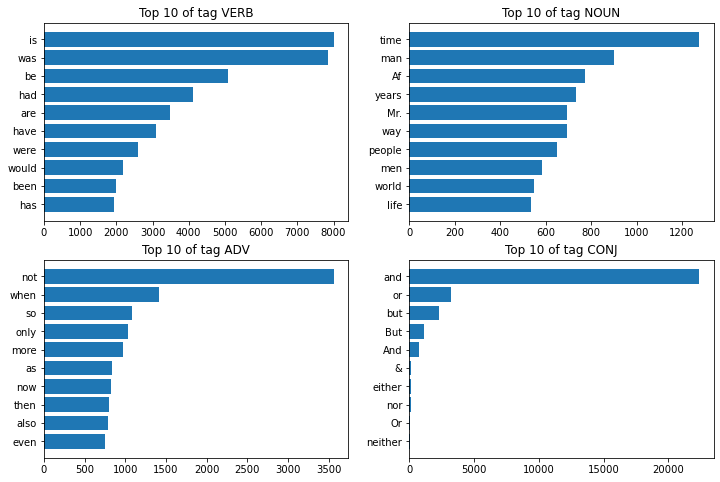

In [108]:
print(word_counts.keys())
def plot_word_count(word_counts, tag, max_count, ax):
    words =  dict(sorted(word_counts[tag].items(), key=lambda item: item[1]))
    #print(words)
    top_words = {r[0]:r[1] for r in list(words.items())[-max_count:]}
    
    ax.barh(*zip(*top_words.items()))
    ax.set_title(f'Top {max_count} of tag {tag}')
    #ax.show()
fig, axs = plt.subplots(2, 2, figsize=(12,8))
plot_word_count(word_counts, 'VERB', 10, axs[0,0])
plot_word_count(word_counts, 'NOUN', 10, axs[0, 1])
plot_word_count(word_counts, 'ADV', 10, axs[1, 0])
plot_word_count(word_counts, 'CONJ', 10, axs[1, 1])

### Making Predictions with a Model
The helper functions provided below interface with Pomegranate network models & the mocked MFCTagger to take advantage of the [missing value](http://pomegranate.readthedocs.io/en/latest/nan.html) functionality in Pomegranate through a simple sequence decoding function. Run these functions, then run the next cell to see some of the predictions made by the MFC tagger.

In [10]:
def replace_unknown(sequence):
    """Return a copy of the input sequence where each unknown word is replaced
    by the literal string value 'nan'. Pomegranate will ignore these values
    during computation.
    """
    return [w if w in data.training_set.vocab else 'nan' for w in sequence]

def simplify_decoding(X, model):
    """X should be a 1-D sequence of observations for the model to predict"""
    _, state_path = model.viterbi(replace_unknown(X))
    return [state[1].name for state in state_path[1:-1]]  # do not show the start/end state predictions

### Example Decoding Sequences with MFC Tagger

In [11]:
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted labels:\n-----------------")
    print(simplify_decoding(data.sentences[key].words, mfc_model))
    print()
    print("Actual labels:\n--------------")
    print(data.sentences[key].tags)
    print("\n")

Sentence Key: b100-28144

Predicted labels:
-----------------
['CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.']

Actual labels:
--------------
('CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.')


Sentence Key: b100-23146

Predicted labels:
-----------------
['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.']

Actual labels:
--------------
('PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.')


Sentence Key: b100-35462

Predicted labels:
-----------------
['DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.', 'ADP', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'DET', '<MISSING>', 'ADP', 'ADJ', 'ADJ', 

### Evaluating Model Accuracy

The function below will evaluate the accuracy of the MFC tagger on the collection of all sentences from a text corpus. 

In [12]:
def accuracy(X, Y, model):
    """Calculate the prediction accuracy by using the model to decode each sequence
    in the input X and comparing the prediction with the true labels in Y.
    
    The X should be an array whose first dimension is the number of sentences to test,
    and each element of the array should be an iterable of the words in the sequence.
    The arrays X and Y should have the exact same shape.
    
    X = [("See", "Spot", "run"), ("Run", "Spot", "run", "fast"), ...]
    Y = [(), (), ...]
    """
    correct = total_predictions = 0
    for observations, actual_tags in zip(X, Y):
        
        # The model.viterbi call in simplify_decoding will return None if the HMM
        # raises an error (for example, if a test sentence contains a word that
        # is out of vocabulary for the training set). Any exception counts the
        # full sentence as an error (which makes this a conservative estimate).
        try:
            most_likely_tags = simplify_decoding(observations, model)
            correct += sum(p == t for p, t in zip(most_likely_tags, actual_tags))
        except:
            pass
        total_predictions += len(observations)
    return correct / total_predictions

#### Evaluate the accuracy of the MFC tagger
Run the next cell to evaluate the accuracy of the tagger on the training and test corpus.

In [13]:
mfc_training_acc = accuracy(data.training_set.X, data.training_set.Y, mfc_model)
print("training accuracy mfc_model: {:.2f}%".format(100 * mfc_training_acc))

mfc_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, mfc_model)
print("testing accuracy mfc_model: {:.2f}%".format(100 * mfc_testing_acc))

assert mfc_training_acc >= 0.955, "Uh oh. Your MFC accuracy on the training set doesn't look right."
assert mfc_testing_acc >= 0.925, "Uh oh. Your MFC accuracy on the testing set doesn't look right."
HTML('<div class="alert alert-block alert-success">Your MFC tagger accuracy looks correct!</div>')

training accuracy mfc_model: 95.72%
testing accuracy mfc_model: 93.02%


## Step 3: Build an HMM tagger
---
The HMM tagger has one hidden state for each possible tag, and parameterized by two distributions: the emission probabilties giving the conditional probability of observing a given **word** from each hidden state, and the transition probabilities giving the conditional probability of moving between **tags** during the sequence.

We will also estimate the starting probability distribution (the probability of each **tag** being the first tag in a sequence), and the terminal probability distribution (the probability of each **tag** being the last tag in a sequence).

The maximum likelihood estimate of these distributions can be calculated from the frequency counts as described in the following sections where you'll implement functions to count the frequencies, and finally build the model. The HMM model will make predictions according to the formula:

$$t_i^n = \underset{t_i^n}{\mathrm{argmax}} \prod_{i=1}^n P(w_i|t_i) P(t_i|t_{i-1})$$

Refer to Speech & Language Processing [Chapter 10](https://web.stanford.edu/~jurafsky/slp3/10.pdf) for more information.

### IMPLEMENTATION: Unigram Counts

Complete the function below to estimate the co-occurrence frequency of each symbol over all of the input sequences. The unigram probabilities in our HMM model are estimated from the formula below, where N is the total number of samples in the input. (You only need to compute the counts for now.)

$$P(tag_1) = \frac{C(tag_1)}{N}$$

In [19]:
line_len = 60
print('data.training_set.X (WORDS)')
print('='*line_len)
max_display = 3
i = 1
for x in data.training_set.X:
    print(x)
    print('-'*line_len)
    i += 1
    if i >= max_display:
        break
        
print('data.training_set.Y (TAGS)')
print('='*line_len)       
i = 1
for x in data.training_set.Y:
    print(x)
    print('-'*line_len)
    i += 1
    if i >= max_display:
        break

data.training_set.X (WORDS)
('Whenever', 'artists', ',', 'indeed', ',', 'turned', 'to', 'actual', 'representations', 'or', 'molded', 'three-dimensional', 'figures', ',', 'which', 'were', 'rare', 'down', 'to', '800', 'B.C.', ',', 'they', 'tended', 'to', 'reflect', 'reality', '(', 'see', 'Plate', '6a', ',', '9b', ')', ';', ';')
------------------------------------------------------------
('For', 'almost', 'two', 'months', ',', 'the', 'defendant', 'and', 'the', 'world', 'heard', 'from', 'individuals', 'escaped', 'from', 'the', 'grave', 'about', 'fathers', 'and', 'mothers', ',', 'graybeards', ',', 'adolescents', ',', 'babies', ',', 'starved', ',', 'beaten', 'to', 'death', ',', 'strangled', ',', 'machine-gunned', ',', 'gassed', ',', 'burned', '.')
------------------------------------------------------------
data.training_set.Y (TAGS)
('ADV', 'NOUN', '.', 'ADV', '.', 'VERB', 'ADP', 'ADJ', 'NOUN', 'CONJ', 'VERB', 'ADJ', 'NOUN', '.', 'DET', 'VERB', 'ADJ', 'PRT', 'ADP', 'NUM', 'NOUN', '.', 'PRO

In [20]:
def unigram_counts(tag_sequences):
    """Return a dictionary keyed to each unique value in the input sequence list that
    counts the number of occurrences of the value in the sequences list. The sequences
    collection should be a 2-dimensional array.
    
    For example, if the tag NOUN appears 275558 times over all the input sequences,
    then you should return a dictionary such that your_unigram_counts[NOUN] == 275558.
    """
    # TODO: Finish this function!
    tag_unigram = dict()
    for tags in tag_sequences:
        for tag in tags:
            tag_count = tag_unigram.get(tag)
            if tag_count is None:
                tag_unigram[tag] = 1
            else:
                tag_unigram[tag] += 1
    return tag_unigram
        

# TODO: call unigram_counts with a list of tag sequences from the training set
tag_unigrams = unigram_counts(data.training_set.Y)# TODO: YOUR CODE HERE)

assert set(tag_unigrams.keys()) == data.training_set.tagset, \
       "Uh oh. It looks like your tag counts doesn't include all the tags!"
assert min(tag_unigrams, key=tag_unigrams.get) == 'X', \
       "Hmmm...'X' is expected to be the least common class"
assert max(tag_unigrams, key=tag_unigrams.get) == 'NOUN', \
       "Hmmm...'NOUN' is expected to be the most common class"
HTML('<div class="alert alert-block alert-success">Your tag unigrams look good!</div>')

### IMPLEMENTATION: Bigram Counts

Complete the function below to estimate the co-occurrence frequency of each pair of symbols in each of the input sequences. These counts are used in the HMM model to estimate the bigram probability of two tags from the frequency counts according to the formula: $$P(tag_2|tag_1) = \frac{C(tag_2|tag_1)}{C(tag_2)}$$


In [34]:
def bigram_counts(tag_sequences):
    """Return a dictionary keyed to each unique PAIR of values in the input sequences
    list that counts the number of occurrences of pair in the sequences list. The input
    should be a 2-dimensional array.
    
    For example, if the pair of tags (NOUN, VERB) appear 61582 times, then you should
    return a dictionary such that your_bigram_counts[(NOUN, VERB)] == 61582
    """

    # TODO: Finish this function!
    tag_bigrams = dict()
    for tags in tag_sequences:
        tag_count = len(tags)
        #print(f'tag count: {tag_count}')
        for i in range(tag_count-1):
            if tag_count > 1:
                key = (tags[i], tags[i+1])
                #print(f'{i} {key}')
            else:
                key = (tags[i])
            tag_pair_count = tag_bigrams.get(key)
            if tag_pair_count is None:
                tag_bigrams[key] = 1
            else:
                tag_bigrams[key] += 1
    return tag_bigrams

# TODO: call bigram_counts with a list of tag sequences from the training set
tag_bigrams = bigram_counts(data.training_set.Y) # TODO: YOUR CODE HERE)

assert len(tag_bigrams) == 144, \
       "Uh oh. There should be 144 pairs of bigrams (12 tags x 12 tags)"
assert min(tag_bigrams, key=tag_bigrams.get) in [('X', 'NUM'), ('PRON', 'X')], \
       "Hmmm...The least common bigram should be one of ('X', 'NUM') or ('PRON', 'X')."
assert max(tag_bigrams, key=tag_bigrams.get) in [('DET', 'NOUN')], \
       "Hmmm...('DET', 'NOUN') is expected to be the most common bigram."
HTML('<div class="alert alert-block alert-success">Your tag bigrams look good!</div>')

### IMPLEMENTATION: Sequence Starting Counts
Complete the code below to estimate the bigram probabilities of a sequence starting with each tag.

In [35]:
def starting_counts(tag_sequences):
    """Return a dictionary keyed to each unique value in the input sequences list
    that counts the number of occurrences where that value is at the beginning of
    a sequence.
    
    For example, if 8093 sequences start with NOUN, then you should return a
    dictionary such that your_starting_counts[NOUN] == 8093
    """
    # TODO: Finish this function!
    starting_counts = dict()
    for tags in tag_sequences:
        key = tags[0]
        s_count = starting_counts.get(key)
        if s_count is None:
            starting_counts[key] = 1
        else:
            starting_counts[key] += 1
    return starting_counts

# TODO: Calculate the count of each tag starting a sequence
tag_starts = starting_counts(data.training_set.Y)# TODO: YOUR CODE HERE)

assert len(tag_starts) == 12, "Uh oh. There should be 12 tags in your dictionary."
assert min(tag_starts, key=tag_starts.get) == 'X', "Hmmm...'X' is expected to be the least common starting bigram."
assert max(tag_starts, key=tag_starts.get) == 'DET', "Hmmm...'DET' is expected to be the most common starting bigram."
HTML('<div class="alert alert-block alert-success">Your starting tag counts look good!</div>')

### IMPLEMENTATION: Sequence Ending Counts
Complete the function below to estimate the bigram probabilities of a sequence ending with each tag.

In [44]:
def ending_counts(tag_sequences):
    """Return a dictionary keyed to each unique value in the input sequences list
    that counts the number of occurrences where that value is at the end of
    a sequence.
    
    For example, if 18 sequences end with DET, then you should return a
    dictionary such that your_starting_counts[DET] == 18
    """
    # TODO: Finish this function!
    ending_counts = dict()
    for tags in tag_sequences:
        
        if len(tags) > 1:
            last_pos = len(tags) - 1
            key = tags[last_pos]
        else:
            key = tags[0]
        s_count = ending_counts.get(key)
        if s_count is None:
            ending_counts[key] = 1
        else:
            ending_counts[key] += 1
    return ending_counts

# TODO: Calculate the count of each tag ending a sequence
tag_ends = ending_counts(data.training_set.Y)# TODO: YOUR CODE HERE)

assert len(tag_ends) == 12, "Uh oh. There should be 12 tags in your dictionary."
assert min(tag_ends, key=tag_ends.get) in ['X', 'CONJ'], "Hmmm...'X' or 'CONJ' should be the least common ending bigram."
assert max(tag_ends, key=tag_ends.get) == '.', "Hmmm...'.' is expected to be the most common ending bigram."
HTML('<div class="alert alert-block alert-success">Your ending tag counts look good!</div>')

### IMPLEMENTATION: Basic HMM Tagger
Use the tag unigrams and bigrams calculated above to construct a hidden Markov tagger.

- Add one state per tag
    - The emission distribution at each state should be estimated with the formula: $P(w|t) = \frac{C(t, w)}{C(t)}$
- Add an edge from the starting state `basic_model.start` to each tag
    - The transition probability should be estimated with the formula: $P(t|start) = \frac{C(start, t)}{C(start)}$
- Add an edge from each tag to the end state `basic_model.end`
    - The transition probability should be estimated with the formula: $P(end|t) = \frac{C(t, end)}{C(t)}$
- Add an edge between _every_ pair of tags
    - The transition probability should be estimated with the formula: $P(t_2|t_1) = \frac{C(t_1, t_2)}{C(t_1)}$

In [48]:
basic_model = HiddenMarkovModel(name="base-hmm-tagger")

for pos_tag in data.tagset:
    emission_probabilities = dict()
    
    for word, count in emission_counts[pos_tag].items(): 
        print(f'pos_tag: {pos_tag} {word} {count} {tag_unigrams[pos_tag]}')
        emission_probabilities[word] = count / tag_unigrams[pos_tag]
# TODO: create states with emission probability distributions P(word | tag) and add to the model
# (Hint: you may need to loop & create/add new states)
basic_model.add_states()

# TODO: add edges between states for the observed transition frequencies P(tag_i | tag_i-1)
# (Hint: you may need to loop & add transitions
basic_model.add_transition()


# NOTE: YOU SHOULD NOT NEED TO MODIFY ANYTHING BELOW THIS LINE
# finalize the model
basic_model.bake()

assert all(tag in set(s.name for s in basic_model.states) for tag in data.training_set.tagset), \
       "Every state in your network should use the name of the associated tag, which must be one of the training set tags."
assert basic_model.edge_count() == 168, \
       ("Your network should have an edge from the start node to each state, one edge between every " +
        "pair of tags (states), and an edge from each state to the end node.")
HTML('<div class="alert alert-block alert-success">Your HMM network topology looks good!</div>')

pos_tag: ADP to 8809 115808
pos_tag: ADP For 522 115808
pos_tag: ADP from 3393 115808
pos_tag: ADP about 972 115808
pos_tag: ADP in 15278 115808
pos_tag: ADP on 4742 115808
pos_tag: ADP for 6979 115808
pos_tag: ADP that 5194 115808
pos_tag: ADP of 28772 115808
pos_tag: ADP like 795 115808
pos_tag: ADP While 96 115808
pos_tag: ADP if 1157 115808
pos_tag: ADP as 4542 115808
pos_tag: ADP with 5610 115808
pos_tag: ADP after 643 115808
pos_tag: ADP by 4051 115808
pos_tag: ADP rather 92 115808
pos_tag: ADP than 1434 115808
pos_tag: ADP since 342 115808
pos_tag: ADP at 3997 115808
pos_tag: ADP so 336 115808
pos_tag: ADP against 491 115808
pos_tag: ADP On 279 115808
pos_tag: ADP through 713 115808
pos_tag: ADP among 258 115808
pos_tag: ADP / 17 115808
pos_tag: ADP As 376 115808
pos_tag: ADP into 1420 115808
pos_tag: ADP between 574 115808
pos_tag: ADP After 191 115808
pos_tag: ADP before 634 115808
pos_tag: ADP At 331 115808
pos_tag: ADP within 245 115808
pos_tag: ADP upon 338 115808
pos_tag: 

pos_tag: NOUN fireplace 5 220632
pos_tag: NOUN desk 48 220632
pos_tag: NOUN bookcase 2 220632
pos_tag: NOUN mahogany 6 220632
pos_tag: NOUN brass 15 220632
pos_tag: NOUN glass 72 220632
pos_tag: NOUN panes 3 220632
pos_tag: NOUN C 101 220632
pos_tag: NOUN energies 9 220632
pos_tag: NOUN population 105 220632
pos_tag: NOUN Mann 2 220632
pos_tag: NOUN incest 11 220632
pos_tag: NOUN comedy 33 220632
pos_tag: NOUN center 146 220632
pos_tag: NOUN myth 32 220632
pos_tag: NOUN truth 96 220632
pos_tag: NOUN dread 7 220632
pos_tag: NOUN joke 13 220632
pos_tag: NOUN credit 37 220632
pos_tag: NOUN Cost 4 220632
pos_tag: NOUN recognition 30 220632
pos_tag: NOUN distinction 36 220632
pos_tag: NOUN utility-cost 1 220632
pos_tag: NOUN analyses 11 220632
pos_tag: NOUN allocation 14 220632
pos_tag: NOUN costs 123 220632
pos_tag: NOUN response 60 220632
pos_tag: NOUN rates 68 220632
pos_tag: NOUN output 27 220632
pos_tag: NOUN classes 66 220632
pos_tag: NOUN utility 23 220632
pos_tag: NOUN Lord 63 22063

pos_tag: NOUN council 19 220632
pos_tag: NOUN Kowalski 13 220632
pos_tag: NOUN Viceroy 1 220632
pos_tag: NOUN FM 2 220632
pos_tag: NOUN outlets 5 220632
pos_tag: NOUN concerts 18 220632
pos_tag: NOUN phenomenon 25 220632
pos_tag: NOUN publicity 23 220632
pos_tag: NOUN drugs 25 220632
pos_tag: NOUN types 95 220632
pos_tag: NOUN fences 13 220632
pos_tag: NOUN lilacs 3 220632
pos_tag: NOUN roses 5 220632
pos_tag: NOUN shorts 20 220632
pos_tag: NOUN campus 25 220632
pos_tag: NOUN Hearst 39 220632
pos_tag: NOUN blame 9 220632
pos_tag: NOUN isolation 11 220632
pos_tag: NOUN disadvantages 6 220632
pos_tag: NOUN charting 3 220632
pos_tag: NOUN litigation 11 220632
pos_tag: NOUN advocates 1 220632
pos_tag: NOUN merit 25 220632
pos_tag: NOUN sequence 29 220632
pos_tag: NOUN contracts 15 220632
pos_tag: NOUN institutions 73 220632
pos_tag: NOUN organizations 53 220632
pos_tag: NOUN polyether 6 220632
pos_tag: NOUN polypropylene 3 220632
pos_tag: NOUN glycol 2 220632
pos_tag: NOUN triol 1 220632
p

pos_tag: NOUN Ramsey 8 220632
pos_tag: NOUN surroundings 5 220632
pos_tag: NOUN cathode 8 220632
pos_tag: NOUN Fury 5 220632
pos_tag: NOUN Hoot 6 220632
pos_tag: NOUN Mon-Fay 2 220632
pos_tag: NOUN Caper 4 220632
pos_tag: NOUN Mon-Columbia 1 220632
pos_tag: NOUN Isaac 9 220632
pos_tag: NOUN Mon-Goddess 2 220632
pos_tag: NOUN Victim 1 220632
pos_tag: NOUN accident 25 220632
pos_tag: NOUN Stansbery 1 220632
pos_tag: NOUN singer 8 220632
pos_tag: NOUN adventures 9 220632
pos_tag: NOUN pitch 17 220632
pos_tag: NOUN lowering 1 220632
pos_tag: NOUN membership 47 220632
pos_tag: NOUN Ranke 1 220632
pos_tag: NOUN dullness 1 220632
pos_tag: NOUN Erikson 6 220632
pos_tag: NOUN indecision 4 220632
pos_tag: NOUN paralysis 5 220632
pos_tag: NOUN workmanship 5 220632
pos_tag: NOUN source 69 220632
pos_tag: NOUN publisher 7 220632
pos_tag: NOUN Orvil 2 220632
pos_tag: NOUN Dryfoos 2 220632
pos_tag: NOUN Times 28 220632
pos_tag: NOUN Sydney 5 220632
pos_tag: NOUN Wragge 1 220632
pos_tag: NOUN casuals 

pos_tag: NOUN anatomical 4 220632
pos_tag: NOUN journalese 2 220632
pos_tag: NOUN dissection 2 220632
pos_tag: NOUN vantage-points 1 220632
pos_tag: NOUN epistemology 3 220632
pos_tag: NOUN contribution 26 220632
pos_tag: NOUN removal 31 220632
pos_tag: NOUN tee 2 220632
pos_tag: NOUN one-iron 1 220632
pos_tag: NOUN bunker 2 220632
pos_tag: NOUN green 16 220632
pos_tag: NOUN paces 6 220632
pos_tag: NOUN feel 14 220632
pos_tag: NOUN hurricane 7 220632
pos_tag: NOUN reel 2 220632
pos_tag: NOUN Robbery 3 220632
pos_tag: NOUN limit 26 220632
pos_tag: NOUN Nation 13 220632
pos_tag: NOUN aisle 3 220632
pos_tag: NOUN Margaret 7 220632
pos_tag: NOUN organdy 3 220632
pos_tag: NOUN sixth-grade 1 220632
pos_tag: NOUN goodness 14 220632
pos_tag: NOUN Bonn 4 220632
pos_tag: NOUN oppressors 2 220632
pos_tag: NOUN self-determination 6 220632
pos_tag: NOUN Katangans 2 220632
pos_tag: NOUN reporter 16 220632
pos_tag: NOUN Lincoln 41 220632
pos_tag: NOUN fashion 50 220632
pos_tag: NOUN valuation 7 22063

pos_tag: NOUN immigration 7 220632
pos_tag: NOUN drunks 2 220632
pos_tag: NOUN carrying 2 220632
pos_tag: NOUN idlers 1 220632
pos_tag: NOUN parasites 3 220632
pos_tag: NOUN urgency 8 220632
pos_tag: NOUN Maria 10 220632
pos_tag: NOUN Remarque's 3 220632
pos_tag: NOUN Marquis 4 220632
pos_tag: NOUN Alfonso 1 220632
pos_tag: NOUN Portago 5 220632
pos_tag: NOUN nobleman 2 220632
pos_tag: NOUN Mille 2 220632
pos_tag: NOUN Miglia 1 220632
pos_tag: NOUN compliment 2 220632
pos_tag: NOUN Innesfree 2 220632
pos_tag: NOUN caps 4 220632
pos_tag: NOUN sweaters 2 220632
pos_tag: NOUN singing 14 220632
pos_tag: NOUN Hetman's 6 220632
pos_tag: NOUN conceits 2 220632
pos_tag: NOUN hatchet 3 220632
pos_tag: NOUN color-TV 2 220632
pos_tag: NOUN $250 3 220632
pos_tag: NOUN consumer 27 220632
pos_tag: NOUN spending 8 220632
pos_tag: NOUN Sixties 11 220632
pos_tag: NOUN backlog 3 220632
pos_tag: NOUN desires 18 220632
pos_tag: NOUN Fifties 4 220632
pos_tag: NOUN scrape 1 220632
pos_tag: NOUN hoof 2 22063

pos_tag: NOUN survivors' 1 220632
pos_tag: NOUN accounts 20 220632
pos_tag: NOUN quarrels 2 220632
pos_tag: NOUN Producer 1 220632
pos_tag: NOUN Holmes 30 220632
pos_tag: NOUN opener 5 220632
pos_tag: NOUN Matunuck 3 220632
pos_tag: NOUN Kerr's 1 220632
pos_tag: NOUN Hearts 2 220632
pos_tag: NOUN squares 10 220632
pos_tag: NOUN Inaugural 3 220632
pos_tag: NOUN woe 4 220632
pos_tag: NOUN offense 7 220632
pos_tag: NOUN doings 3 220632
pos_tag: NOUN humanist 1 220632
pos_tag: NOUN John-and-Linda 4 220632
pos_tag: NOUN Conneaut 1 220632
pos_tag: NOUN Eve 11 220632
pos_tag: NOUN vows 3 220632
pos_tag: NOUN fundamentals 3 220632
pos_tag: NOUN Sesame 2 220632
pos_tag: NOUN pods 1 220632
pos_tag: NOUN toasted-nut 1 220632
pos_tag: NOUN dish 10 220632
pos_tag: NOUN almonds 2 220632
pos_tag: NOUN configuration 3 220632
pos_tag: NOUN aeon 1 220632
pos_tag: NOUN Powell's 2 220632
pos_tag: NOUN brother-in-law 3 220632
pos_tag: NOUN Keane 2 220632
pos_tag: NOUN compulsivity 12 220632
pos_tag: NOUN c

pos_tag: NOUN tape 24 220632
pos_tag: NOUN Douglass 7 220632
pos_tag: NOUN crystal 15 220632
pos_tag: NOUN x-ray 5 220632
pos_tag: NOUN iodocompounds 1 220632
pos_tag: NOUN openings 6 220632
pos_tag: NOUN expansions 2 220632
pos_tag: NOUN graduating 1 220632
pos_tag: NOUN drilling 1 220632
pos_tag: NOUN requirement 26 220632
pos_tag: NOUN Elman 4 220632
pos_tag: NOUN SS 4 220632
pos_tag: NOUN thermostats 1 220632
pos_tag: NOUN fueloil 2 220632
pos_tag: NOUN installation 11 220632
pos_tag: NOUN Requests 3 220632
pos_tag: NOUN antiques 3 220632
pos_tag: NOUN pretext 2 220632
pos_tag: NOUN calcium 5 220632
pos_tag: NOUN Nicolas 12 220632
pos_tag: NOUN Poussin 2 220632
pos_tag: NOUN Giles 6 220632
pos_tag: NOUN Governor-General 1 220632
pos_tag: NOUN compilation 8 220632
pos_tag: NOUN public-address 1 220632
pos_tag: NOUN Finals 7 220632
pos_tag: NOUN Hogan 8 220632
pos_tag: NOUN Welcome 2 220632
pos_tag: NOUN Cafe 1 220632
pos_tag: NOUN Childhood's 3 220632
pos_tag: NOUN End 5 220632
pos_

pos_tag: NOUN Sky 2 220632
pos_tag: NOUN Speeches 1 220632
pos_tag: NOUN vogue 3 220632
pos_tag: NOUN Rotarians 1 220632
pos_tag: NOUN Miriani's 1 220632
pos_tag: NOUN Mayor-elect 1 220632
pos_tag: NOUN Cavanagh 1 220632
pos_tag: NOUN mid-June 2 220632
pos_tag: NOUN Kansas-Nebraska 1 220632
pos_tag: NOUN canvas 14 220632
pos_tag: NOUN Rossoff 5 220632
pos_tag: NOUN rag 7 220632
pos_tag: NOUN snack 4 220632
pos_tag: NOUN dip 3 220632
pos_tag: NOUN architect's 2 220632
pos_tag: NOUN Willow 1 220632
pos_tag: NOUN Electric's 1 220632
pos_tag: NOUN Louisville 5 220632
pos_tag: NOUN Syracuse 1 220632
pos_tag: NOUN Pentagon 10 220632
pos_tag: NOUN Boeing 3 220632
pos_tag: NOUN Lockheed 2 220632
pos_tag: NOUN disorder 7 220632
pos_tag: NOUN coordinator 5 220632
pos_tag: NOUN Francis 18 220632
pos_tag: NOUN Nolan 1 220632
pos_tag: NOUN practicing 1 220632
pos_tag: NOUN fountains 3 220632
pos_tag: NOUN springtime 3 220632
pos_tag: NOUN creche 1 220632
pos_tag: NOUN Cat 1 220632
pos_tag: NOUN Fly

pos_tag: NOUN mayonnaise 2 220632
pos_tag: NOUN Bassis 1 220632
pos_tag: NOUN Methyl 1 220632
pos_tag: NOUN polysiloxanes 1 220632
pos_tag: NOUN rally 4 220632
pos_tag: NOUN Picasso 11 220632
pos_tag: NOUN Braque 6 220632
pos_tag: NOUN representational 2 220632
pos_tag: NOUN Gildas 1 220632
pos_tag: NOUN Chronicles 1 220632
pos_tag: NOUN Guest 5 220632
pos_tag: NOUN Urbano 1 220632
pos_tag: NOUN Quintana 1 220632
pos_tag: NOUN rulers 7 220632
pos_tag: NOUN statue 12 220632
pos_tag: NOUN twos 2 220632
pos_tag: NOUN Garibaldi's 7 220632
pos_tag: NOUN Porta 1 220632
pos_tag: NOUN Pancrazio 1 220632
pos_tag: NOUN Villa 3 220632
pos_tag: NOUN Doria 2 220632
pos_tag: NOUN Pamphili 1 220632
pos_tag: NOUN Wergeland 1 220632
pos_tag: NOUN Clive 1 220632
pos_tag: NOUN high-quality 2 220632
pos_tag: NOUN mos. 1 220632
pos_tag: NOUN tombstones 1 220632
pos_tag: NOUN Livingston 1 220632
pos_tag: NOUN Birdwood 1 220632
pos_tag: NOUN Uprising 1 220632
pos_tag: NOUN mercenaries 9 220632
pos_tag: NOUN 

pos_tag: NOUN Norris-LaGuardia 1 220632
pos_tag: NOUN issuance 7 220632
pos_tag: NOUN injunctions 4 220632
pos_tag: NOUN local 3 220632
pos_tag: NOUN international 1 220632
pos_tag: NOUN arcs 7 220632
pos_tag: NOUN fluxes 4 220632
pos_tag: NOUN Kyne 2 220632
pos_tag: NOUN Pride 2 220632
pos_tag: NOUN Palomar 1 220632
pos_tag: NOUN debates 4 220632
pos_tag: NOUN Californians 1 220632
pos_tag: NOUN upperclassmen 1 220632
pos_tag: NOUN creeds 1 220632
pos_tag: NOUN dogmas 2 220632
pos_tag: NOUN credo 7 220632
pos_tag: NOUN respondent's 1 220632
pos_tag: NOUN interviewer 2 220632
pos_tag: NOUN Turin 2 220632
pos_tag: NOUN swellings 2 220632
pos_tag: NOUN taxpayers' 2 220632
pos_tag: NOUN battleground 1 220632
pos_tag: NOUN moderates 1 220632
pos_tag: NOUN regulation 7 220632
pos_tag: NOUN bronc 2 220632
pos_tag: NOUN $5-8,000 1 220632
pos_tag: NOUN bracket 1 220632
pos_tag: NOUN roadster 1 220632
pos_tag: NOUN Mayer 3 220632
pos_tag: NOUN McCullough 1 220632
pos_tag: NOUN Elec 8 220632
pos

pos_tag: NOUN Oils 1 220632
pos_tag: NOUN flax 3 220632
pos_tag: NOUN tung 2 220632
pos_tag: NOUN casualties 2 220632
pos_tag: NOUN vise 1 220632
pos_tag: NOUN domains 3 220632
pos_tag: NOUN fellowfeeling 1 220632
pos_tag: NOUN Ihmsen 1 220632
pos_tag: NOUN canvass 2 220632
pos_tag: NOUN frock 2 220632
pos_tag: NOUN Filippo 2 220632
pos_tag: NOUN Oso's 2 220632
pos_tag: NOUN Statues 1 220632
pos_tag: NOUN Crusaders 2 220632
pos_tag: NOUN mammals 3 220632
pos_tag: NOUN Bill's 2 220632
pos_tag: NOUN closet 10 220632
pos_tag: NOUN aromas 2 220632
pos_tag: NOUN Araby 1 220632
pos_tag: NOUN Chmn. 1 220632
pos_tag: NOUN Juniors' 1 220632
pos_tag: NOUN tropics 1 220632
pos_tag: NOUN Lubberlanders 1 220632
pos_tag: NOUN Homemaster 1 220632
pos_tag: NOUN Routo-Jig 1 220632
pos_tag: NOUN Cable 2 220632
pos_tag: NOUN Venable 1 220632
pos_tag: NOUN redecoration 2 220632
pos_tag: NOUN hypotheses 2 220632
pos_tag: NOUN Jellyby 1 220632
pos_tag: NOUN Firzite 1 220632
pos_tag: NOUN Beatrice 5 220632
p

pos_tag: NOUN Gazette 4 220632
pos_tag: NOUN Zeiss 2 220632
pos_tag: NOUN mercury 4 220632
pos_tag: NOUN Osram 1 220632
pos_tag: NOUN HBO 1 220632
pos_tag: NOUN satin 4 220632
pos_tag: NOUN princesse 2 220632
pos_tag: NOUN bateau 2 220632
pos_tag: NOUN Protests 1 220632
pos_tag: NOUN intendants 1 220632
pos_tag: NOUN insurrections 1 220632
pos_tag: NOUN brushwork 1 220632
pos_tag: NOUN accordion 1 220632
pos_tag: NOUN Freida 1 220632
pos_tag: NOUN Bahia 1 220632
pos_tag: NOUN Cabana 1 220632
pos_tag: NOUN calypso 1 220632
pos_tag: NOUN capers 1 220632
pos_tag: NOUN Mayflower 4 220632
pos_tag: NOUN devil's 2 220632
pos_tag: NOUN positivism 2 220632
pos_tag: NOUN parliament 3 220632
pos_tag: NOUN judiciary 1 220632
pos_tag: NOUN Michaelson 1 220632
pos_tag: NOUN $9.2 1 220632
pos_tag: NOUN $10.1 1 220632
pos_tag: NOUN Chef 1 220632
pos_tag: NOUN Yokel 1 220632
pos_tag: NOUN shrimp 1 220632
pos_tag: NOUN $20,000,000,000 1 220632
pos_tag: NOUN DiSimone 1 220632
pos_tag: NOUN Tolek 1 220632

pos_tag: NOUN McLemore 1 220632
pos_tag: NOUN inwardness 1 220632
pos_tag: NOUN highboy 1 220632
pos_tag: NOUN Alva 1 220632
pos_tag: NOUN Edison's 1 220632
pos_tag: NOUN minorities 5 220632
pos_tag: NOUN minstrels 1 220632
pos_tag: NOUN parable 2 220632
pos_tag: NOUN chantey 2 220632
pos_tag: NOUN chanter 1 220632
pos_tag: NOUN boat-yard 1 220632
pos_tag: NOUN suburbia 1 220632
pos_tag: NOUN hearth 3 220632
pos_tag: NOUN Basel 2 220632
pos_tag: NOUN stepmothers 2 220632
pos_tag: NOUN Couperin 2 220632
pos_tag: NOUN Steinkerque 1 220632
pos_tag: NOUN brevity 3 220632
pos_tag: NOUN Corelli 1 220632
pos_tag: NOUN mid-century 1 220632
pos_tag: NOUN elegances 1 220632
pos_tag: NOUN Peking 1 220632
pos_tag: NOUN Mongolia's 1 220632
pos_tag: NOUN determinability 1 220632
pos_tag: NOUN midmorning 1 220632
pos_tag: NOUN Hyannis 2 220632
pos_tag: NOUN Bunny 1 220632
pos_tag: NOUN itinerary 2 220632
pos_tag: NOUN 1940's 1 220632
pos_tag: NOUN avocation 1 220632
pos_tag: NOUN Royal 1 220632
pos_t

pos_tag: NOUN Bugatti 1 220632
pos_tag: NOUN Farina 1 220632
pos_tag: NOUN coachwork 1 220632
pos_tag: NOUN chassis 1 220632
pos_tag: NOUN Swallow 1 220632
pos_tag: NOUN A40-AjK 1 220632
pos_tag: NOUN Mercedes 1 220632
pos_tag: NOUN metronome 1 220632
pos_tag: NOUN degradation 2 220632
pos_tag: NOUN Alpers 2 220632
pos_tag: NOUN Petermann 1 220632
pos_tag: NOUN Verdi 3 220632
pos_tag: NOUN slitters 1 220632
pos_tag: NOUN fascicles 2 220632
pos_tag: NOUN Tumor 2 220632
pos_tag: NOUN Rodney-Honor 1 220632
pos_tag: NOUN Spahnie 1 220632
pos_tag: NOUN Enos 1 220632
pos_tag: NOUN hick 1 220632
pos_tag: NOUN Whitman's 1 220632
pos_tag: NOUN regiments 1 220632
pos_tag: NOUN Kingston 2 220632
pos_tag: NOUN Jen 6 220632
pos_tag: NOUN windfall 2 220632
pos_tag: NOUN Dixiecrats 1 220632
pos_tag: NOUN twinkle 2 220632
pos_tag: NOUN oilheating 1 220632
pos_tag: NOUN yelling 1 220632
pos_tag: NOUN handfuls 1 220632
pos_tag: NOUN Harrow 1 220632
pos_tag: NOUN chant 1 220632
pos_tag: NOUN fervor 2 220

pos_tag: NOUN niger 1 220632
pos_tag: NOUN Bacillus 1 220632
pos_tag: NOUN globigii 1 220632
pos_tag: NOUN colonials 1 220632
pos_tag: NOUN Schuman 1 220632
pos_tag: NOUN Billings 1 220632
pos_tag: NOUN woodwind 2 220632
pos_tag: NOUN Teamsters 1 220632
pos_tag: NOUN Sumatra 1 220632
pos_tag: NOUN niggers 2 220632
pos_tag: NOUN beeps 3 220632
pos_tag: NOUN Belt 3 220632
pos_tag: NOUN Boa 1 220632
pos_tag: NOUN tractor-trailer 1 220632
pos_tag: NOUN Snellville 2 220632
pos_tag: NOUN Alusik 1 220632
pos_tag: NOUN Cooke 3 220632
pos_tag: NOUN Existence 1 220632
pos_tag: NOUN Bravado 2 220632
pos_tag: NOUN larkspur 1 220632
pos_tag: NOUN Admiralty 1 220632
pos_tag: NOUN Wynn 1 220632
pos_tag: NOUN Heel-Kaola 1 220632
pos_tag: NOUN Karet 1 220632
pos_tag: NOUN instigator 1 220632
pos_tag: NOUN Sea-road 1 220632
pos_tag: NOUN trucker 1 220632
pos_tag: NOUN Dream-Next 1 220632
pos_tag: NOUN Irvin 1 220632
pos_tag: NOUN cuff 1 220632
pos_tag: NOUN nightshirt 1 220632
pos_tag: NOUN 8% 2 220632


pos_tag: NOUN McGruder 1 220632
pos_tag: NOUN Buena 1 220632
pos_tag: NOUN Vista 1 220632
pos_tag: NOUN Terrace 1 220632
pos_tag: NOUN enunciation 1 220632
pos_tag: NOUN $63.8 1 220632
pos_tag: NOUN Sandra 1 220632
pos_tag: NOUN Branum 1 220632
pos_tag: NOUN McRoberts 1 220632
pos_tag: NOUN debacle 2 220632
pos_tag: NOUN advisement 1 220632
pos_tag: NOUN Crane's 1 220632
pos_tag: NOUN newspapers' 1 220632
pos_tag: NOUN sabre-rattling 1 220632
pos_tag: NOUN picker 1 220632
pos_tag: NOUN $2,700 1 220632
pos_tag: NOUN Eaton 2 220632
pos_tag: NOUN Carolyn 1 220632
pos_tag: NOUN Bert 1 220632
pos_tag: NOUN 1770's 1 220632
pos_tag: NOUN Dupont 1 220632
pos_tag: NOUN Escape's 1 220632
pos_tag: NOUN Bonanza 1 220632
pos_tag: NOUN bonanza 1 220632
pos_tag: NOUN ballyhoo 1 220632
pos_tag: NOUN advisory 1 220632
pos_tag: NOUN $581,000 1 220632
pos_tag: NOUN H.L. 1 220632
pos_tag: NOUN Zachrisson's 1 220632
pos_tag: NOUN Kelts 1 220632
pos_tag: NOUN H.P.R. 1 220632
pos_tag: NOUN Finberg 2 220632
p

pos_tag: NOUN Boss 1 220632
pos_tag: NOUN gripes 1 220632
pos_tag: NOUN Raymont 1 220632
pos_tag: NOUN Berrellez 1 220632
pos_tag: NOUN slick 1 220632
pos_tag: NOUN third-dimensionality 1 220632
pos_tag: NOUN round-table 1 220632
pos_tag: NOUN baying 1 220632
pos_tag: NOUN Alton 2 220632
pos_tag: NOUN Cater 1 220632
pos_tag: NOUN Parmer 1 220632
pos_tag: NOUN Tau 1 220632
pos_tag: NOUN Omega 1 220632
pos_tag: NOUN Sigma 1 220632
pos_tag: NOUN Grahamstown 1 220632
pos_tag: NOUN cost-billing 1 220632
pos_tag: NOUN turnery 1 220632
pos_tag: NOUN hodgepodge 1 220632
pos_tag: NOUN cobwebs 1 220632
pos_tag: NOUN Taruffi 1 220632
pos_tag: NOUN riddles 2 220632
pos_tag: NOUN Elks 1 220632
pos_tag: NOUN tannin 1 220632
pos_tag: NOUN hilltops 1 220632
pos_tag: NOUN caper 1 220632
pos_tag: NOUN Lorena 1 220632
pos_tag: NOUN Gallon 1 220632
pos_tag: NOUN Gallon-Loren 1 220632
pos_tag: NOUN distresses 1 220632
pos_tag: NOUN fledglings 1 220632
pos_tag: NOUN concentrate 1 220632
pos_tag: NOUN Hazard

pos_tag: NOUN reams 1 220632
pos_tag: NOUN $12.50 1 220632
pos_tag: NOUN $11.50 1 220632
pos_tag: NOUN Xydis' 1 220632
pos_tag: NOUN Mendelssohn's 1 220632
pos_tag: NOUN quick-kill 1 220632
pos_tag: NOUN Bernhardt 1 220632
pos_tag: NOUN Bakhtiari 1 220632
pos_tag: NOUN khan 1 220632
pos_tag: NOUN cross-fertilization 1 220632
pos_tag: NOUN riots 1 220632
pos_tag: NOUN Athena 1 220632
pos_tag: NOUN committeemen 1 220632
pos_tag: NOUN Feds 1 220632
pos_tag: NOUN Himmler 1 220632
pos_tag: NOUN Lublin's 1 220632
pos_tag: NOUN fountainhead 1 220632
pos_tag: NOUN KKK 1 220632
pos_tag: NOUN Rink 1 220632
pos_tag: NOUN Bonito 1 220632
pos_tag: NOUN Lavato 1 220632
pos_tag: NOUN Chavez' 1 220632
pos_tag: NOUN adjuncts 1 220632
pos_tag: NOUN gauze 1 220632
pos_tag: NOUN Evegeni 1 220632
pos_tag: NOUN Dubovskoi 1 220632
pos_tag: NOUN concertmaster 1 220632
pos_tag: NOUN Lumia 1 220632
pos_tag: NOUN sunspot 1 220632
pos_tag: NOUN grad 1 220632
pos_tag: NOUN bullhide 1 220632
pos_tag: NOUN Pops's 1 

pos_tag: ADJ provisional 3 66754
pos_tag: ADJ unenunciated 1 66754
pos_tag: ADJ undefined 2 66754
pos_tag: ADJ darkling 1 66754
pos_tag: ADJ dilute 1 66754
pos_tag: ADJ gentler 3 66754
pos_tag: ADJ mule-drawn 1 66754
pos_tag: ADJ groundless 1 66754
pos_tag: ADJ aforementioned 1 66754
pos_tag: ADJ slack 4 66754
pos_tag: ADJ unpleasant 10 66754
pos_tag: ADJ disgusting 4 66754
pos_tag: ADJ incorrigible 1 66754
pos_tag: ADJ incredible 19 66754
pos_tag: ADJ Circular 2 66754
pos_tag: ADJ restorative 7 66754
pos_tag: ADJ Hon. 3 66754
pos_tag: ADJ faint 21 66754
pos_tag: ADJ luminescent 1 66754
pos_tag: ADJ baggy 2 66754
pos_tag: ADJ disturbing 13 66754
pos_tag: ADJ tactual 7 66754
pos_tag: ADJ undamaged 1 66754
pos_tag: ADJ movable 16 66754
pos_tag: ADJ Popular 2 66754
pos_tag: ADJ tenable 4 66754
pos_tag: ADJ Lateral 1 66754
pos_tag: ADJ back 22 66754
pos_tag: ADJ stern 11 66754
pos_tag: ADJ clumsy 6 66754
pos_tag: ADJ alert 19 66754
pos_tag: ADJ careless 6 66754
pos_tag: ADJ restrictive 6 6

pos_tag: ADJ Buddhist 3 66754
pos_tag: ADJ on-again-off-again 1 66754
pos_tag: ADJ sedentary 1 66754
pos_tag: ADJ endothelial 1 66754
pos_tag: ADJ two-system 2 66754
pos_tag: ADJ precision 2 66754
pos_tag: ADJ forty-fifth 1 66754
pos_tag: ADJ Ardent 1 66754
pos_tag: ADJ opinionated 2 66754
pos_tag: ADJ obstinate 1 66754
pos_tag: ADJ articulate 5 66754
pos_tag: ADJ hard-fought 2 66754
pos_tag: ADJ militant 4 66754
pos_tag: ADJ wide-shouldered 1 66754
pos_tag: ADJ inexpert 1 66754
pos_tag: ADJ edgy 2 66754
pos_tag: ADJ head-in-the-clouds 1 66754
pos_tag: ADJ flawless 2 66754
pos_tag: ADJ erect 6 66754
pos_tag: ADJ languid 4 66754
pos_tag: ADJ restful 3 66754
pos_tag: ADJ incarnate 1 66754
pos_tag: ADJ indolent 3 66754
pos_tag: ADJ luxurious 6 66754
pos_tag: ADJ birdlike 1 66754
pos_tag: ADJ upstairs 4 66754
pos_tag: ADJ Enough 3 66754
pos_tag: ADJ 12-passenger 1 66754
pos_tag: ADJ instructive 3 66754
pos_tag: ADJ ethnic 8 66754
pos_tag: ADJ Anti-A 1 66754
pos_tag: ADJ anti-B 4 66754
pos_

pos_tag: ADJ nationalist 1 66754
pos_tag: ADJ irreversible 2 66754
pos_tag: ADJ light-hearted 1 66754
pos_tag: ADJ manure-scented 1 66754
pos_tag: ADJ non-service-connected 4 66754
pos_tag: ADJ unsmiling 2 66754
pos_tag: ADJ irksome 1 66754
pos_tag: ADJ unrifled 1 66754
pos_tag: ADJ undeniable 5 66754
pos_tag: ADJ cute 5 66754
pos_tag: ADJ Hon'ble 2 66754
pos_tag: ADJ Apropos 1 66754
pos_tag: ADJ philosophic 6 66754
pos_tag: ADJ Microscopic 3 66754
pos_tag: ADJ unsightly 1 66754
pos_tag: ADJ well-meaning 3 66754
pos_tag: ADJ adjustable 1 66754
pos_tag: ADJ exact-size 1 66754
pos_tag: ADJ morphemic 1 66754
pos_tag: ADJ cut-to-a-familiar-pattern 1 66754
pos_tag: ADJ bluff 1 66754
pos_tag: ADJ awe-inspiring 1 66754
pos_tag: ADJ Heavy-coated 1 66754
pos_tag: ADJ severe-looking 1 66754
pos_tag: ADJ Orphic 1 66754
pos_tag: ADJ Hungarian-born 1 66754
pos_tag: ADJ libelous 1 66754
pos_tag: ADJ eighteenth- 1 66754
pos_tag: ADJ cockier 1 66754
pos_tag: ADJ non-verbal 2 66754
pos_tag: ADJ toilsom

pos_tag: ADJ over-the-counter 1 66754
pos_tag: ADJ applause-happy 1 66754
pos_tag: ADJ isotropic 1 66754
pos_tag: ADJ typewritten 1 66754
pos_tag: ADJ prompt 2 66754
pos_tag: ADJ Choctaw 1 66754
pos_tag: ADJ bargain-priced 1 66754
pos_tag: ADJ South-East 1 66754
pos_tag: ADJ land-locked 1 66754
pos_tag: ADJ mustached 2 66754
pos_tag: ADJ many-faced 1 66754
pos_tag: ADJ boxy 1 66754
pos_tag: ADJ care-free 1 66754
pos_tag: ADJ Vietnamese 2 66754
pos_tag: ADJ authoritarian 3 66754
pos_tag: ADJ bigoted 1 66754
pos_tag: ADJ imperious 1 66754
pos_tag: ADJ twenty-mile 1 66754
pos_tag: ADJ unfulfilled 1 66754
pos_tag: ADJ waterproof 2 66754
pos_tag: ADJ big-chested 1 66754
pos_tag: ADJ big-shouldered 1 66754
pos_tag: ADJ heavy-armed 1 66754
pos_tag: ADJ nociceptive 2 66754
pos_tag: ADJ interspecies 1 66754
pos_tag: ADJ syntactic 1 66754
pos_tag: ADJ spice-laden 1 66754
pos_tag: ADJ unanalyzed 2 66754
pos_tag: ADJ miasmal 1 66754
pos_tag: ADJ brimful 1 66754
pos_tag: ADJ wont 2 66754
pos_tag: A

pos_tag: ADJ two-room 1 66754
pos_tag: ADJ Explicit 1 66754
pos_tag: ADJ renal 1 66754
pos_tag: ADJ celiac 1 66754
pos_tag: ADJ iliac 1 66754
pos_tag: ADJ unwaivering 1 66754
pos_tag: ADJ wild-eyed 1 66754
pos_tag: ADJ tumultuous 1 66754
pos_tag: ADJ dust-thick 1 66754
pos_tag: ADJ oneasy 1 66754
pos_tag: ADJ longitudinal 1 66754
pos_tag: ADJ realest 1 66754
pos_tag: ADJ Greasy 1 66754
pos_tag: ADJ budget-wise 1 66754
pos_tag: ADJ Highest 1 66754
pos_tag: ADJ olden 1 66754
pos_tag: ADJ Christmas-season 1 66754
pos_tag: ADJ unsprayed 1 66754
pos_tag: ADJ distraught 1 66754
pos_tag: ADJ oviform 1 66754
pos_tag: ADJ 4-cell 1 66754
pos_tag: ADJ 150-milliampere 1 66754
pos_tag: ADJ flashlight-type 1 66754
pos_tag: ADJ polycrystalline 1 66754
pos_tag: ADJ two-bedroom 1 66754
pos_tag: ADJ Glorious 1 66754
pos_tag: ADJ mightiest 1 66754
pos_tag: ADJ agile 1 66754
pos_tag: ADJ gray-thatched 1 66754
pos_tag: ADJ thickest 1 66754
pos_tag: ADJ matrimonial 1 66754
pos_tag: ADJ Broad 1 66754
pos_tag

pos_tag: PRT Sssshoo 1 23906
pos_tag: PRT Half 4 23906
pos_tag: PRT oystchers'll 1 23906
pos_tag: PRT Crunch 1 23906
pos_tag: PRT damnit 1 23906
pos_tag: PRT camera's 1 23906
pos_tag: PRT oh 5 23906
pos_tag: PRT Off 3 23906
pos_tag: PRT that'd 1 23906
pos_tag: PRT bang 2 23906
pos_tag: PRT leg's 1 23906
pos_tag: PRT Golly 1 23906
pos_tag: PRT Who'd 1 23906
pos_tag: PRT Oooo 1 23906
pos_tag: PRT Pa'd 1 23906
pos_tag: PRT You'd 5 23906
pos_tag: PRT Pugh 1 23906
pos_tag: PRT Many 5 23906
pos_tag: PRT tarantara 1 23906
pos_tag: PRT rum-tum-tum 1 23906
pos_tag: PRT boom-boom-boom 1 23906
pos_tag: PRT level's 1 23906
pos_tag: PRT Toot 3 23906
pos_tag: PRT Aw 1 23906
pos_tag: PRT She'll 5 23906
pos_tag: PRT hello 2 23906
pos_tag: PRT Bye 1 23906
pos_tag: PRT Where's 6 23906
pos_tag: PRT Y're 1 23906
pos_tag: PRT else's 7 23906
pos_tag: PRT ahem 1 23906
pos_tag: PRT ba-a-a 1 23906
pos_tag: PRT cowhand'd 1 23906
pos_tag: PRT cane's 1 23906
pos_tag: PRT goddamit 1 23906
pos_tag: PRT Hubba 1 2390

pos_tag: VERB swimming 25 146161
pos_tag: VERB skyjacked 1 146161
pos_tag: VERB operates 13 146161
pos_tag: VERB submerged 6 146161
pos_tag: VERB becoming 39 146161
pos_tag: VERB stamped 6 146161
pos_tag: VERB chinked 1 146161
pos_tag: VERB crouch 2 146161
pos_tag: VERB tenting 1 146161
pos_tag: VERB laid 67 146161
pos_tag: VERB dried 22 146161
pos_tag: VERB dying 22 146161
pos_tag: VERB Contact 4 146161
pos_tag: VERB moved 133 146161
pos_tag: VERB expanded 16 146161
pos_tag: VERB jarred 2 146161
pos_tag: VERB embarrassing 9 146161
pos_tag: VERB promise 5 146161
pos_tag: VERB cost 37 146161
pos_tag: VERB met 103 146161
pos_tag: VERB simmer 3 146161
pos_tag: VERB rejects 7 146161
pos_tag: VERB Suspecting 1 146161
pos_tag: VERB swamped 1 146161
pos_tag: VERB likes 16 146161
pos_tag: VERB eats 1 146161
pos_tag: VERB dissatisfied 5 146161
pos_tag: VERB rolled 39 146161
pos_tag: VERB translate 14 146161
pos_tag: VERB failed 62 146161
pos_tag: VERB alienated 5 146161
pos_tag: VERB expecting 

pos_tag: VERB deepen 1 146161
pos_tag: VERB postulate 3 146161
pos_tag: VERB matched 14 146161
pos_tag: VERB buy 58 146161
pos_tag: VERB Retired 1 146161
pos_tag: VERB Halting 1 146161
pos_tag: VERB survey 3 146161
pos_tag: VERB Granted 3 146161
pos_tag: VERB composed 27 146161
pos_tag: VERB trembling 21 146161
pos_tag: VERB shines 3 146161
pos_tag: VERB preceded 11 146161
pos_tag: VERB publicizing 2 146161
pos_tag: VERB distributed 26 146161
pos_tag: VERB urge 9 146161
pos_tag: VERB showing 48 146161
pos_tag: VERB stamp 5 146161
pos_tag: VERB boiled 8 146161
pos_tag: VERB equipped 29 146161
pos_tag: VERB vent 2 146161
pos_tag: VERB opposing 11 146161
pos_tag: VERB cite 6 146161
pos_tag: VERB Strike 3 146161
pos_tag: VERB retrieved 9 146161
pos_tag: VERB sells 9 146161
pos_tag: VERB thin 2 146161
pos_tag: VERB recede 3 146161
pos_tag: VERB dispatch 2 146161
pos_tag: VERB grunted 8 146161
pos_tag: VERB consuming 5 146161
pos_tag: VERB combine 11 146161
pos_tag: VERB heaved 4 146161
pos_

pos_tag: VERB infest 1 146161
pos_tag: VERB purify 2 146161
pos_tag: VERB trilled 1 146161
pos_tag: VERB tickled 2 146161
pos_tag: VERB affirmed 5 146161
pos_tag: VERB chinning 2 146161
pos_tag: VERB reconsider 4 146161
pos_tag: VERB clerk 1 146161
pos_tag: VERB feted 2 146161
pos_tag: VERB glorified 4 146161
pos_tag: VERB taming 1 146161
pos_tag: VERB watering 2 146161
pos_tag: VERB lure 3 146161
pos_tag: VERB supplemented 6 146161
pos_tag: VERB promoting 10 146161
pos_tag: VERB persevere 1 146161
pos_tag: VERB certified 7 146161
pos_tag: VERB divide 9 146161
pos_tag: VERB illumined 2 146161
pos_tag: VERB mentioning 4 146161
pos_tag: VERB paie 3 146161
pos_tag: VERB borrowing 3 146161
pos_tag: VERB moistening 1 146161
pos_tag: VERB shape 6 146161
pos_tag: VERB accentuated 3 146161
pos_tag: VERB hogging 1 146161
pos_tag: VERB participating 10 146161
pos_tag: VERB approximated 5 146161
pos_tag: VERB preserved 16 146161
pos_tag: VERB fort 1 146161
pos_tag: VERB clarifying 3 146161
pos_ta

pos_tag: VERB steal 5 146161
pos_tag: VERB coloring 3 146161
pos_tag: VERB peer 1 146161
pos_tag: VERB colonized 1 146161
pos_tag: VERB sired 3 146161
pos_tag: VERB reciting 2 146161
pos_tag: VERB yellin' 1 146161
pos_tag: VERB jaded 2 146161
pos_tag: VERB rely 11 146161
pos_tag: VERB bellowed 6 146161
pos_tag: VERB robbing 2 146161
pos_tag: VERB detract 1 146161
pos_tag: VERB musing 1 146161
pos_tag: VERB flattering 1 146161
pos_tag: VERB plugged 2 146161
pos_tag: VERB analysed 1 146161
pos_tag: VERB barging 1 146161
pos_tag: VERB counterbalance 1 146161
pos_tag: VERB induced 9 146161
pos_tag: VERB modernized 3 146161
pos_tag: VERB Continuing 3 146161
pos_tag: VERB persisting 2 146161
pos_tag: VERB surpassed 2 146161
pos_tag: VERB minifying 1 146161
pos_tag: VERB magnifying 3 146161
pos_tag: VERB arisen 3 146161
pos_tag: VERB careened 1 146161
pos_tag: VERB inquire 6 146161
pos_tag: VERB verified 5 146161
pos_tag: VERB roused 2 146161
pos_tag: VERB substantiate 2 146161
pos_tag: VERB 

pos_tag: VERB adjourned 1 146161
pos_tag: VERB aspires 1 146161
pos_tag: VERB purified 7 146161
pos_tag: VERB corrode 1 146161
pos_tag: VERB synthesized 2 146161
pos_tag: VERB intrigued 2 146161
pos_tag: VERB page 1 146161
pos_tag: VERB Inject 1 146161
pos_tag: VERB throwin' 4 146161
pos_tag: VERB capped 2 146161
pos_tag: VERB conquer 3 146161
pos_tag: VERB Letting 1 146161
pos_tag: VERB debuts 1 146161
pos_tag: VERB recouped 1 146161
pos_tag: VERB prepackaged 2 146161
pos_tag: VERB deducted 2 146161
pos_tag: VERB wakes 1 146161
pos_tag: VERB availing 1 146161
pos_tag: VERB reeled 1 146161
pos_tag: VERB crashing 6 146161
pos_tag: VERB convalescing 1 146161
pos_tag: VERB snuck 1 146161
pos_tag: VERB gumming 1 146161
pos_tag: VERB lapping 2 146161
pos_tag: VERB purchases 2 146161
pos_tag: VERB assigns 2 146161
pos_tag: VERB cropping 1 146161
pos_tag: VERB distract 2 146161
pos_tag: VERB outlining 1 146161
pos_tag: VERB Alarmed 1 146161
pos_tag: VERB averted 2 146161
pos_tag: VERB officer

pos_tag: VERB butts 1 146161
pos_tag: VERB scented 3 146161
pos_tag: VERB cascades 1 146161
pos_tag: VERB mineralized 1 146161
pos_tag: VERB revved 1 146161
pos_tag: VERB Treat 1 146161
pos_tag: VERB over-stitched 1 146161
pos_tag: VERB evolves 1 146161
pos_tag: VERB Avowed 1 146161
pos_tag: VERB swivels 1 146161
pos_tag: VERB Select 1 146161
pos_tag: VERB deceives 1 146161
pos_tag: VERB Construct 1 146161
pos_tag: VERB fertilized 2 146161
pos_tag: VERB consigned 1 146161
pos_tag: VERB haunting 1 146161
pos_tag: VERB Flying 4 146161
pos_tag: VERB initialed 1 146161
pos_tag: VERB simmered 1 146161
pos_tag: VERB berated 2 146161
pos_tag: VERB outwit 1 146161
pos_tag: VERB meanin' 1 146161
pos_tag: VERB attaches 2 146161
pos_tag: VERB specializes 1 146161
pos_tag: VERB realigning 1 146161
pos_tag: VERB snows 3 146161
pos_tag: VERB Gratified 1 146161
pos_tag: VERB Citing 1 146161
pos_tag: VERB Combined 1 146161
pos_tag: VERB hop 1 146161
pos_tag: VERB Squeezed 1 146161
pos_tag: VERB inculc

pos_tag: ADV more 968 44877
pos_tag: ADV away 360 44877
pos_tag: ADV when 1410 44877
pos_tag: ADV also 793 44877
pos_tag: ADV usually 151 44877
pos_tag: ADV sometimes 132 44877
pos_tag: ADV where 677 44877
pos_tag: ADV preferably 8 44877
pos_tag: ADV because 116 44877
pos_tag: ADV about 422 44877
pos_tag: ADV especially 116 44877
pos_tag: ADV manifestly 5 44877
pos_tag: ADV now 823 44877
pos_tag: ADV why 194 44877
pos_tag: ADV heavily 47 44877
pos_tag: ADV just 584 44877
pos_tag: ADV once 281 44877
pos_tag: ADV only 1032 44877
pos_tag: ADV honestly 11 44877
pos_tag: ADV steadily 16 44877
pos_tag: ADV unblinkingly 2 44877
pos_tag: ADV Just 91 44877
pos_tag: ADV else 130 44877
pos_tag: ADV very 543 44877
pos_tag: ADV much 350 44877
pos_tag: ADV right 156 44877
pos_tag: ADV voraciously 1 44877
pos_tag: ADV well 551 44877
pos_tag: ADV Because 21 44877
pos_tag: ADV doubtless 9 44877
pos_tag: ADV farther 26 44877
pos_tag: ADV negatively 2 44877
pos_tag: ADV later 248 44877
pos_tag: ADV curre

pos_tag: ADV overland 1 44877
pos_tag: ADV oftentimes 2 44877
pos_tag: ADV wolfishly 1 44877
pos_tag: ADV governmentally 1 44877
pos_tag: ADV tactually 1 44877
pos_tag: ADV competitively 1 44877
pos_tag: ADV askance 1 44877
pos_tag: ADV tartly 1 44877
pos_tag: ADV south 1 44877
pos_tag: ADV categorically 1 44877
pos_tag: ADV irredeemably 1 44877
pos_tag: ADV absurdly 1 44877
pos_tag: ADV upland 1 44877
pos_tag: ADV admiringly 1 44877
pos_tag: ADV asunder 1 44877
pos_tag: ADV unobtrusively 1 44877
pos_tag: ADV nakedly 1 44877
pos_tag: ADV no-o 1 44877
pos_tag: ADV egregiously 1 44877
pos_tag: ADV worriedly 1 44877
pos_tag: ADV soe 1 44877
pos_tag: ADV habitually 2 44877
pos_tag: ADV thereunder 1 44877
pos_tag: ADV quantitatively 1 44877
pos_tag: ADV qualitatively 1 44877
pos_tag: ADV anciently 1 44877
pos_tag: ADV homeward 1 44877
pos_tag: ADV insolently 1 44877
pos_tag: ADV kinda 4 44877
pos_tag: ADV uncomplainingly 1 44877
pos_tag: ADV cold 2 44877
pos_tag: ADV syntactically 1 44877
p

TypeError: add_transition() takes at least 3 positional arguments (0 given)

In [ ]:
hmm_training_acc = accuracy(data.training_set.X, data.training_set.Y, basic_model)
print("training accuracy basic hmm model: {:.2f}%".format(100 * hmm_training_acc))

hmm_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, basic_model)
print("testing accuracy basic hmm model: {:.2f}%".format(100 * hmm_testing_acc))

assert hmm_training_acc > 0.97, "Uh oh. Your HMM accuracy on the training set doesn't look right."
assert hmm_testing_acc > 0.955, "Uh oh. Your HMM accuracy on the testing set doesn't look right."
HTML('<div class="alert alert-block alert-success">Your HMM tagger accuracy looks correct! Congratulations, you\'ve finished the project.</div>')

### Example Decoding Sequences with the HMM Tagger

In [ ]:
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted labels:\n-----------------")
    print(simplify_decoding(data.sentences[key].words, basic_model))
    print()
    print("Actual labels:\n--------------")
    print(data.sentences[key].tags)
    print("\n")


## Finishing the project
---

<div class="alert alert-block alert-info">
**Note:** **SAVE YOUR NOTEBOOK**, then run the next cell to generate an HTML copy. You will zip & submit both this file and the HTML copy for review.
</div>

In [ ]:
!!jupyter nbconvert *.ipynb

## Step 4: [Optional] Improving model performance
---
There are additional enhancements that can be incorporated into your tagger that improve performance on larger tagsets where the data sparsity problem is more significant. The data sparsity problem arises because the same amount of data split over more tags means there will be fewer samples in each tag, and there will be more missing data  tags that have zero occurrences in the data. The techniques in this section are optional.

- [Laplace Smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) (pseudocounts)
    Laplace smoothing is a technique where you add a small, non-zero value to all observed counts to offset for unobserved values.

- Backoff Smoothing
    Another smoothing technique is to interpolate between n-grams for missing data. This method is more effective than Laplace smoothing at combatting the data sparsity problem. Refer to chapters 4, 9, and 10 of the [Speech & Language Processing](https://web.stanford.edu/~jurafsky/slp3/) book for more information.

- Extending to Trigrams
    HMM taggers have achieved better than 96% accuracy on this dataset with the full Penn treebank tagset using an architecture described in [this](http://www.coli.uni-saarland.de/~thorsten/publications/Brants-ANLP00.pdf) paper. Altering your HMM to achieve the same performance would require implementing deleted interpolation (described in the paper), incorporating trigram probabilities in your frequency tables, and re-implementing the Viterbi algorithm to consider three consecutive states instead of two.

### Obtain the Brown Corpus with a Larger Tagset
Run the code below to download a copy of the brown corpus with the full NLTK tagset. You will need to research the available tagset information in the NLTK docs and determine the best way to extract the subset of NLTK tags you want to explore. If you write the following the format specified in Step 1, then you can reload the data using all of the code above for comparison.

Refer to [Chapter 5](http://www.nltk.org/book/ch05.html) of the NLTK book for more information on the available tagsets.

In [ ]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import brown

nltk.download('brown')
training_corpus = nltk.corpus.brown
training_corpus.tagged_sents()[0]